## Importing Libraries

In [141]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score,roc_curve,classification_report,confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV,KFold
from keras.layers  import Dense,Input
from keras.models import Model


## Loading Data

In [142]:
data=pd.read_excel("Train.xlsx",header=0)
test=pd.read_excel("Test.xlsx",header=0)

In [143]:
data.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious
0,Rep10101,C21116,PR6112,182,1665,indeterminate
1,Rep10102,C21116,PR6112,182,1740,indeterminate
2,Rep10103,C21116,PR6253,101,1040,indeterminate
3,Rep10104,C21116,PR6253,283,4495,No
4,Rep10105,C21116,PR6294,108,1465,indeterminate


In [144]:
test.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue
0,Rep70101,C21844,PR6483,102,1115
1,Rep70102,C21844,PR6251,102,1050
2,Rep70103,C21844,PR6253,344,3490
3,Rep70104,C21844,PR6378,108,1095
4,Rep70105,C21844,PR6463,146,1055


In [145]:
#data.drop("ReportID",axis=1,inplace=True)

In [146]:
data.columns

Index(['ReportID', 'SalesPersonID', 'ProductID', 'Quantity', 'TotalSalesValue',
       'Suspicious'],
      dtype='object')

## Feature engineering

In [147]:
data["per_unit_price"]=data.TotalSalesValue/data.Quantity
test["per_unit_price"]=test.TotalSalesValue/test.Quantity

In [148]:
print(data.head())
print(test.head())

   ReportID SalesPersonID ProductID  Quantity  TotalSalesValue     Suspicious  \
0  Rep10101        C21116    PR6112       182             1665  indeterminate   
1  Rep10102        C21116    PR6112       182             1740  indeterminate   
2  Rep10103        C21116    PR6253       101             1040  indeterminate   
3  Rep10104        C21116    PR6253       283             4495             No   
4  Rep10105        C21116    PR6294       108             1465  indeterminate   

   per_unit_price  
0        9.148352  
1        9.560440  
2       10.297030  
3       15.883392  
4       13.564815  
   ReportID SalesPersonID ProductID  Quantity  TotalSalesValue  per_unit_price
0  Rep70101        C21844    PR6483       102             1115       10.931373
1  Rep70102        C21844    PR6251       102             1050       10.294118
2  Rep70103        C21844    PR6253       344             3490       10.145349
3  Rep70104        C21844    PR6378       108             1095       10.13888

#### Average quantity per salesperson per product

In [149]:
temp_tr=data.groupby(["SalesPersonID","ProductID"]).mean()['Quantity']
temp_ts=test.groupby(["SalesPersonID","ProductID"]).mean()['Quantity']

In [150]:
temp_tr = (pd.DataFrame(temp_tr))
temp_tr = temp_tr.reset_index()
result_tr=pd.merge(data,temp_tr,on=['SalesPersonID','ProductID'],how='left')

In [151]:
temp_ts = (pd.DataFrame(temp_ts))
temp_ts = temp_ts.reset_index()
result_ts=pd.merge(test,temp_ts,on=['SalesPersonID','ProductID'],how='left')

In [152]:
result_tr.head()

,ReportID,SalesPersonID,ProductID,Quantity_x,TotalSalesValue,Suspicious,per_unit_price,Quantity_y
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.5


In [153]:
result_ts.head()

,ReportID,SalesPersonID,ProductID,Quantity_x,TotalSalesValue,per_unit_price,Quantity_y
0,Rep70101,C21844,PR6483,102,1115,10.931373,102.0
1,Rep70102,C21844,PR6251,102,1050,10.294118,102.0
2,Rep70103,C21844,PR6253,344,3490,10.145349,225.5
3,Rep70104,C21844,PR6378,108,1095,10.138889,108.0
4,Rep70105,C21844,PR6463,146,1055,7.226027,155.8


In [154]:
data=pd.merge(data,temp_tr,on=['SalesPersonID','ProductID'],how='left')
test=pd.merge(test,temp_ts,on=['SalesPersonID','ProductID'],how='left')
data=data.rename(index=str, columns={"Quantity_y": "avg_qnt_per_s_per_p"})
test=test.rename(index=str, columns={"Quantity_y": "avg_qnt_per_s_per_p"})

In [155]:
data=data.rename(index=str, columns={"Quantity_x":"Quantity"})
test=test.rename(index=str, columns={"Quantity_x":"Quantity"})

In [156]:
test.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,per_unit_price,avg_qnt_per_s_per_p
0,Rep70101,C21844,PR6483,102,1115,10.931373,102.0
1,Rep70102,C21844,PR6251,102,1050,10.294118,102.0
2,Rep70103,C21844,PR6253,344,3490,10.145349,225.5
3,Rep70104,C21844,PR6378,108,1095,10.138889,108.0
4,Rep70105,C21844,PR6463,146,1055,7.226027,155.8


In [157]:
data.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious,per_unit_price,avg_qnt_per_s_per_p
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.5


### per SalesPerson per Product Total TotalSalesValue

In [158]:
df6 = data.groupby(['SalesPersonID','ProductID'])[['TotalSalesValue']].sum()
df6=df6.rename(columns={'TotalSalesValue': 'PP for SalesP'})
data = data.join(df6,on=['SalesPersonID','ProductID'])

In [159]:
data.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.5,3325


In [160]:
ef6 = test.groupby(['SalesPersonID','ProductID'])[['TotalSalesValue']].sum()
ef6 = ef6.rename(columns={'TotalSalesValue': 'PP for SalesP'})
test = test.join(ef6,on=['SalesPersonID','ProductID'])

In [161]:
test.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP
0,Rep70101,C21844,PR6483,102,1115,10.931373,102.0,4460
1,Rep70102,C21844,PR6251,102,1050,10.294118,102.0,4200
2,Rep70103,C21844,PR6253,344,3490,10.145349,225.5,4505
3,Rep70104,C21844,PR6378,108,1095,10.138889,108.0,4380
4,Rep70105,C21844,PR6463,146,1055,7.226027,155.8,5355


### per SalesPerson per Product TotalQuantity

In [162]:
ef7 = test.groupby(['SalesPersonID','ProductID'])[['Quantity']].sum()
ef7 = ef7.rename(columns={'Quantity': 'Total Pro SSP'})
test = test.join(ef7,on=['SalesPersonID','ProductID'])


In [163]:
test.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP
0,Rep70101,C21844,PR6483,102,1115,10.931373,102.0,4460,408
1,Rep70102,C21844,PR6251,102,1050,10.294118,102.0,4200,408
2,Rep70103,C21844,PR6253,344,3490,10.145349,225.5,4505,451
3,Rep70104,C21844,PR6378,108,1095,10.138889,108.0,4380,432
4,Rep70105,C21844,PR6463,146,1055,7.226027,155.8,5355,779


In [164]:
df7 = data.groupby(['SalesPersonID','ProductID'])[['Quantity']].sum()
df7 = df7.rename(columns={'Quantity': 'Total Pro SSP'})
data = data.join(df7,on=['SalesPersonID','ProductID'])

In [165]:
data.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145,546
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145,546
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310,908
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310,908
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.5,3325,225


### per Product mean per unit price

In [166]:
temp_tr=data.groupby(["ProductID"]).agg({"per_unit_price":"mean"})
temp_tr=pd.DataFrame(temp_tr)
temp_tr = temp_tr.reset_index()
data=pd.merge(data,temp_tr,on=['ProductID'],how='left')
data.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious,per_unit_price_x,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_unit_price_y
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145,546,14.164825
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145,546,14.164825
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310,908,16.161482
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310,908,16.161482
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.5,3325,225,20.898267


In [167]:
temp_ts=test.groupby(["ProductID"]).agg({"per_unit_price":"mean"})
temp_ts=pd.DataFrame(temp_ts)
temp_ts = temp_ts.reset_index()
test=pd.merge(test,temp_ts,on=['ProductID'],how='left')
test.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,per_unit_price_x,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_unit_price_y
0,Rep70101,C21844,PR6483,102,1115,10.931373,102.0,4460,408,9.589537
1,Rep70102,C21844,PR6251,102,1050,10.294118,102.0,4200,408,10.807918
2,Rep70103,C21844,PR6253,344,3490,10.145349,225.5,4505,451,12.240047
3,Rep70104,C21844,PR6378,108,1095,10.138889,108.0,4380,432,20.299865
4,Rep70105,C21844,PR6463,146,1055,7.226027,155.8,5355,779,8.386834


In [168]:
data= data.rename(columns = {"per_unit_price_y": "per_prd_per_unit_price","per_unit_price_x":"per_unit_price"})
test= test.rename(columns = {"per_unit_price_y": "per_prd_per_unit_price","per_unit_price_x":"per_unit_price"})

### Difference between per transaction per unit price and per product mean per unit price

In [169]:
data["diff_bw_pertrnsctn_untprice_per_prdunitprice"]=data.per_unit_price-data.per_prd_per_unit_price
test["diff_bw_pertrnsctn_untprice_per_prdunitprice"]=test.per_unit_price-test.per_prd_per_unit_price

### Number of transactions per product

In [170]:
temp_tr=data.groupby('ProductID').agg({'SalesPersonID':'count'}) 
temp_tr=pd.DataFrame(temp_tr)
temp_tr = temp_tr.reset_index()
data=pd.merge(data,temp_tr,on=['ProductID'],how='left')
data.head()

,ReportID,SalesPersonID_x,ProductID,Quantity,TotalSalesValue,Suspicious,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,SalesPersonID_y
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145,546,14.164825,-5.016473,169
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145,546,14.164825,-4.604385,169
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310,908,16.161482,-5.864452,2590
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310,908,16.161482,-0.278089,2590
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.5,3325,225,20.898267,-7.333452,141


In [171]:
temp_ts=test.groupby('ProductID').agg({'SalesPersonID':'count'}) 
temp_ts=pd.DataFrame(temp_ts)
temp_ts = temp_ts.reset_index()
test=pd.merge(test,temp_ts,on=['ProductID'],how='left')
test.head()

,ReportID,SalesPersonID_x,ProductID,Quantity,TotalSalesValue,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,SalesPersonID_y
0,Rep70101,C21844,PR6483,102,1115,10.931373,102.0,4460,408,9.589537,1.341835,47
1,Rep70102,C21844,PR6251,102,1050,10.294118,102.0,4200,408,10.807918,-0.513800,65
2,Rep70103,C21844,PR6253,344,3490,10.145349,225.5,4505,451,12.240047,-2.094698,604
3,Rep70104,C21844,PR6378,108,1095,10.138889,108.0,4380,432,20.299865,-10.160976,79
4,Rep70105,C21844,PR6463,146,1055,7.226027,155.8,5355,779,8.386834,-1.160807,11


In [172]:
data= data.rename(columns = {"SalesPersonID_y": "no_trnsctn_fora_prdct","SalesPersonID_x":"SalesPersonID"})
test= test.rename(columns = {"SalesPersonID_y": "no_trnsctn_fora_prdct","SalesPersonID_x":"SalesPersonID"})

In [173]:
data.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145,546,14.164825,-5.016473,169
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145,546,14.164825,-4.604385,169
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310,908,16.161482,-5.864452,2590
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310,908,16.161482,-0.278089,2590
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.5,3325,225,20.898267,-7.333452,141


In [174]:
test.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct
0,Rep70101,C21844,PR6483,102,1115,10.931373,102.0,4460,408,9.589537,1.341835,47
1,Rep70102,C21844,PR6251,102,1050,10.294118,102.0,4200,408,10.807918,-0.513800,65
2,Rep70103,C21844,PR6253,344,3490,10.145349,225.5,4505,451,12.240047,-2.094698,604
3,Rep70104,C21844,PR6378,108,1095,10.138889,108.0,4380,432,20.299865,-10.160976,79
4,Rep70105,C21844,PR6463,146,1055,7.226027,155.8,5355,779,8.386834,-1.160807,11


### per SalesPerson per Product  mean TotalSalesValue

In [175]:
temp_tr=data.groupby(["SalesPersonID","ProductID"]).mean()['TotalSalesValue']
temp_tr = (pd.DataFrame(temp_tr))
temp_tr = temp_tr.reset_index()
data=pd.merge(data,temp_tr,on=['SalesPersonID','ProductID'],how='left')

In [176]:
temp_ts=test.groupby(["SalesPersonID","ProductID"]).mean()['TotalSalesValue']
temp_ts = (pd.DataFrame(temp_ts))
temp_ts = temp_ts.reset_index()
test=pd.merge(test,temp_ts,on=['SalesPersonID','ProductID'],how='left')

In [177]:
data.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue_x,Suspicious,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,TotalSalesValue_y
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145,546,14.164825,-5.016473,169,1715.0
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145,546,14.164825,-4.604385,169,1715.0
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310,908,16.161482,-5.864452,2590,3327.5
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310,908,16.161482,-0.278089,2590,3327.5
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.5,3325,225,20.898267,-7.333452,141,1662.5


In [178]:
test.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue_x,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,TotalSalesValue_y
0,Rep70101,C21844,PR6483,102,1115,10.931373,102.0,4460,408,9.589537,1.341835,47,1115.0
1,Rep70102,C21844,PR6251,102,1050,10.294118,102.0,4200,408,10.807918,-0.513800,65,1050.0
2,Rep70103,C21844,PR6253,344,3490,10.145349,225.5,4505,451,12.240047,-2.094698,604,2252.5
3,Rep70104,C21844,PR6378,108,1095,10.138889,108.0,4380,432,20.299865,-10.160976,79,1095.0
4,Rep70105,C21844,PR6463,146,1055,7.226027,155.8,5355,779,8.386834,-1.160807,11,1071.0


In [179]:
data= data.rename(columns = {"TotalSalesValue_y": "avg_Totsls_per_s_per_p","TotalSalesValue_x":"TotalSalesValue"})
test= test.rename(columns = {"TotalSalesValue_y": "avg_Totsls_per_s_per_p","TotalSalesValue_x":"TotalSalesValue"})

In [180]:
data.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145,546,14.164825,-5.016473,169,1715.0
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145,546,14.164825,-4.604385,169,1715.0
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310,908,16.161482,-5.864452,2590,3327.5
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310,908,16.161482,-0.278089,2590,3327.5
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.5,3325,225,20.898267,-7.333452,141,1662.5


In [181]:
test.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p
0,Rep70101,C21844,PR6483,102,1115,10.931373,102.0,4460,408,9.589537,1.341835,47,1115.0
1,Rep70102,C21844,PR6251,102,1050,10.294118,102.0,4200,408,10.807918,-0.513800,65,1050.0
2,Rep70103,C21844,PR6253,344,3490,10.145349,225.5,4505,451,12.240047,-2.094698,604,2252.5
3,Rep70104,C21844,PR6378,108,1095,10.138889,108.0,4380,432,20.299865,-10.160976,79,1095.0
4,Rep70105,C21844,PR6463,146,1055,7.226027,155.8,5355,779,8.386834,-1.160807,11,1071.0


### per Salesperson mean TotalSalesValue

In [182]:
temp_tr=data.groupby(['SalesPersonID']).mean()['TotalSalesValue']
temp_tr=pd.DataFrame(temp_tr)
data=pd.merge(data,temp_tr,on=['SalesPersonID'],how='left')
data.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue_x,Suspicious,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,TotalSalesValue_y
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145,546,14.164825,-5.016473,169,1715.0,2408.0
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145,546,14.164825,-4.604385,169,1715.0,2408.0
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310,908,16.161482,-5.864452,2590,3327.5,2408.0
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310,908,16.161482,-0.278089,2590,3327.5,2408.0
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.5,3325,225,20.898267,-7.333452,141,1662.5,2408.0


In [183]:
temp_ts=test.groupby(['SalesPersonID']).mean()['TotalSalesValue']
temp_ts=pd.DataFrame(temp_ts)
test=pd.merge(test,temp_ts,on=['SalesPersonID'],how='left')
test.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue_x,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,TotalSalesValue_y
0,Rep70101,C21844,PR6483,102,1115,10.931373,102.0,4460,408,9.589537,1.341835,47,1115.0,1422.0
1,Rep70102,C21844,PR6251,102,1050,10.294118,102.0,4200,408,10.807918,-0.513800,65,1050.0,1422.0
2,Rep70103,C21844,PR6253,344,3490,10.145349,225.5,4505,451,12.240047,-2.094698,604,2252.5,1422.0
3,Rep70104,C21844,PR6378,108,1095,10.138889,108.0,4380,432,20.299865,-10.160976,79,1095.0,1422.0
4,Rep70105,C21844,PR6463,146,1055,7.226027,155.8,5355,779,8.386834,-1.160807,11,1071.0,1422.0


In [184]:
data= data.rename(columns = {"TotalSalesValue_y": "avg_Totsls_per_s","TotalSalesValue_x":"TotalSalesValue"})
test= test.rename(columns = {"TotalSalesValue_y": "avg_Totsls_per_s","TotalSalesValue_x":"TotalSalesValue"})
data.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,avg_Totsls_per_s
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145,546,14.164825,-5.016473,169,1715.0,2408.0
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145,546,14.164825,-4.604385,169,1715.0,2408.0
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310,908,16.161482,-5.864452,2590,3327.5,2408.0
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310,908,16.161482,-0.278089,2590,3327.5,2408.0
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.5,3325,225,20.898267,-7.333452,141,1662.5,2408.0


### per Salesperson average Quantity sold

In [185]:
temp_tr=data.groupby(['SalesPersonID']).mean()['Quantity']
temp_tr=pd.DataFrame(temp_tr)
data=pd.merge(data,temp_tr,on=['SalesPersonID'],how='left')
data.head()

,ReportID,SalesPersonID,ProductID,Quantity_x,TotalSalesValue,Suspicious,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,avg_Totsls_per_s,Quantity_y
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145,546,14.164825,-5.016473,169,1715.0,2408.0,182.9
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145,546,14.164825,-4.604385,169,1715.0,2408.0,182.9
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310,908,16.161482,-5.864452,2590,3327.5,2408.0,182.9
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310,908,16.161482,-0.278089,2590,3327.5,2408.0,182.9
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.5,3325,225,20.898267,-7.333452,141,1662.5,2408.0,182.9


In [186]:
temp_ts=test.groupby(['SalesPersonID']).mean()['Quantity']
temp_ts=pd.DataFrame(temp_ts)
test=pd.merge(test,temp_ts,on=['SalesPersonID'],how='left')
test.head()

,ReportID,SalesPersonID,ProductID,Quantity_x,TotalSalesValue,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,avg_Totsls_per_s,Quantity_y
0,Rep70101,C21844,PR6483,102,1115,10.931373,102.0,4460,408,9.589537,1.341835,47,1115.0,1422.0,147.3
1,Rep70102,C21844,PR6251,102,1050,10.294118,102.0,4200,408,10.807918,-0.513800,65,1050.0,1422.0,147.3
2,Rep70103,C21844,PR6253,344,3490,10.145349,225.5,4505,451,12.240047,-2.094698,604,2252.5,1422.0,147.3
3,Rep70104,C21844,PR6378,108,1095,10.138889,108.0,4380,432,20.299865,-10.160976,79,1095.0,1422.0,147.3
4,Rep70105,C21844,PR6463,146,1055,7.226027,155.8,5355,779,8.386834,-1.160807,11,1071.0,1422.0,147.3


In [187]:
data= data.rename(columns = {"Quantity_y": "avg_Qnt_per_s","Quantity_x":"Quantity"})
test= test.rename(columns = {"Quantity_y": "avg_Qnt_per_s","Quantity_x":"Quantity"})
data.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,avg_Totsls_per_s,avg_Qnt_per_s
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145,546,14.164825,-5.016473,169,1715.0,2408.0,182.9
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145,546,14.164825,-4.604385,169,1715.0,2408.0,182.9
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310,908,16.161482,-5.864452,2590,3327.5,2408.0,182.9
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310,908,16.161482,-0.278089,2590,3327.5,2408.0,182.9
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.5,3325,225,20.898267,-7.333452,141,1662.5,2408.0,182.9


In [188]:
data.dtypes

ReportID                                         object
SalesPersonID                                    object
ProductID                                        object
Quantity                                          int64
TotalSalesValue                                   int64
Suspicious                                       object
per_unit_price                                  float64
avg_qnt_per_s_per_p                             float64
PP for SalesP                                     int64
Total Pro SSP                                     int64
per_prd_per_unit_price                          float64
diff_bw_pertrnsctn_untprice_per_prdunitprice    float64
no_trnsctn_fora_prdct                             int64
avg_Totsls_per_s_per_p                          float64
avg_Totsls_per_s                                float64
avg_Qnt_per_s                                   float64
dtype: object

In [189]:
data.avg_qnt_per_s_per_p=round(data.avg_qnt_per_s_per_p,0)
data.avg_Qnt_per_s=round(data.avg_Qnt_per_s,0)

test.avg_qnt_per_s_per_p=round(test.avg_qnt_per_s_per_p,0)
test.avg_Qnt_per_s=round(test.avg_Qnt_per_s,0)

In [190]:
data.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,avg_Totsls_per_s,avg_Qnt_per_s
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145,546,14.164825,-5.016473,169,1715.0,2408.0,183.0
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145,546,14.164825,-4.604385,169,1715.0,2408.0,183.0
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310,908,16.161482,-5.864452,2590,3327.5,2408.0,183.0
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310,908,16.161482,-0.278089,2590,3327.5,2408.0,183.0
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.0,3325,225,20.898267,-7.333452,141,1662.5,2408.0,183.0


### per product average TotalSalesValue

In [191]:
temp_tr=data.groupby(["ProductID"]).mean()["TotalSalesValue"]
temp_tr=pd.DataFrame(temp_tr)
data=pd.merge(data,temp_tr,on=['ProductID'],how='left')
data.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue_x,Suspicious,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,avg_Totsls_per_s,avg_Qnt_per_s,TotalSalesValue_y
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145,546,14.164825,-5.016473,169,1715.0,2408.0,183.0,6876.035503
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145,546,14.164825,-4.604385,169,1715.0,2408.0,183.0,6876.035503
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310,908,16.161482,-5.864452,2590,3327.5,2408.0,183.0,5612.323552
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310,908,16.161482,-0.278089,2590,3327.5,2408.0,183.0,5612.323552
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.0,3325,225,20.898267,-7.333452,141,1662.5,2408.0,183.0,5203.262411


In [192]:
temp_ts=test.groupby(["ProductID"]).mean()["TotalSalesValue"]
temp_ts=pd.DataFrame(temp_ts)
test=pd.merge(test,temp_ts,on=['ProductID'],how='left')
test.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue_x,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,avg_Totsls_per_s,avg_Qnt_per_s,TotalSalesValue_y
0,Rep70101,C21844,PR6483,102,1115,10.931373,102.0,4460,408,9.589537,1.341835,47,1115.0,1422.0,147.0,1840.106383
1,Rep70102,C21844,PR6251,102,1050,10.294118,102.0,4200,408,10.807918,-0.513800,65,1050.0,1422.0,147.0,3268.692308
2,Rep70103,C21844,PR6253,344,3490,10.145349,226.0,4505,451,12.240047,-2.094698,604,2252.5,1422.0,147.0,5101.100993
3,Rep70104,C21844,PR6378,108,1095,10.138889,108.0,4380,432,20.299865,-10.160976,79,1095.0,1422.0,147.0,2788.544304
4,Rep70105,C21844,PR6463,146,1055,7.226027,156.0,5355,779,8.386834,-1.160807,11,1071.0,1422.0,147.0,1558.636364


In [193]:
data= data.rename(columns = {"TotalSalesValue_y": "avg_sale_per_prd","TotalSalesValue_x":"TotalSalesValue"})
test= test.rename(columns = {"TotalSalesValue_y": "avg_sale_per_prd","TotalSalesValue_x":"TotalSalesValue"})
data.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,avg_Totsls_per_s,avg_Qnt_per_s,avg_sale_per_prd
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145,546,14.164825,-5.016473,169,1715.0,2408.0,183.0,6876.035503
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145,546,14.164825,-4.604385,169,1715.0,2408.0,183.0,6876.035503
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310,908,16.161482,-5.864452,2590,3327.5,2408.0,183.0,5612.323552
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310,908,16.161482,-0.278089,2590,3327.5,2408.0,183.0,5612.323552
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.0,3325,225,20.898267,-7.333452,141,1662.5,2408.0,183.0,5203.262411


### per product average Quantity sold

In [194]:
temp_tr=data.groupby(["ProductID"]).mean()["Quantity"]
temp_tr=pd.DataFrame(temp_tr)
data=pd.merge(data,temp_tr,on=['ProductID'],how='left')
data.head()

,ReportID,SalesPersonID,ProductID,Quantity_x,TotalSalesValue,Suspicious,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,avg_Totsls_per_s,avg_Qnt_per_s,avg_sale_per_prd,Quantity_y
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145,546,14.164825,-5.016473,169,1715.0,2408.0,183.0,6876.035503,591.650888
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145,546,14.164825,-4.604385,169,1715.0,2408.0,183.0,6876.035503,591.650888
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310,908,16.161482,-5.864452,2590,3327.5,2408.0,183.0,5612.323552,471.563320
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310,908,16.161482,-0.278089,2590,3327.5,2408.0,183.0,5612.323552,471.563320
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.0,3325,225,20.898267,-7.333452,141,1662.5,2408.0,183.0,5203.262411,224.248227


In [195]:
temp_ts=test.groupby(["ProductID"]).mean()["Quantity"]
temp_ts=pd.DataFrame(temp_ts)
test=pd.merge(test,temp_ts,on=['ProductID'],how='left')
test.head()

,ReportID,SalesPersonID,ProductID,Quantity_x,TotalSalesValue,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,avg_Totsls_per_s,avg_Qnt_per_s,avg_sale_per_prd,Quantity_y
0,Rep70101,C21844,PR6483,102,1115,10.931373,102.0,4460,408,9.589537,1.341835,47,1115.0,1422.0,147.0,1840.106383,192.702128
1,Rep70102,C21844,PR6251,102,1050,10.294118,102.0,4200,408,10.807918,-0.513800,65,1050.0,1422.0,147.0,3268.692308,387.523077
2,Rep70103,C21844,PR6253,344,3490,10.145349,226.0,4505,451,12.240047,-2.094698,604,2252.5,1422.0,147.0,5101.100993,729.142384
3,Rep70104,C21844,PR6378,108,1095,10.138889,108.0,4380,432,20.299865,-10.160976,79,1095.0,1422.0,147.0,2788.544304,130.835443
4,Rep70105,C21844,PR6463,146,1055,7.226027,156.0,5355,779,8.386834,-1.160807,11,1071.0,1422.0,147.0,1558.636364,204.454545


In [196]:
data= data.rename(columns = {"Quantity_y": "avg_qnt_per_prd","Quantity_x":"Quantity"})
test= test.rename(columns = {"Quantity_y": "avg_qnt_per_prd","Quantity_x":"Quantity"})
data.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,avg_Totsls_per_s,avg_Qnt_per_s,avg_sale_per_prd,avg_qnt_per_prd
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145,546,14.164825,-5.016473,169,1715.0,2408.0,183.0,6876.035503,591.650888
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145,546,14.164825,-4.604385,169,1715.0,2408.0,183.0,6876.035503,591.650888
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310,908,16.161482,-5.864452,2590,3327.5,2408.0,183.0,5612.323552,471.563320
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310,908,16.161482,-0.278089,2590,3327.5,2408.0,183.0,5612.323552,471.563320
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.0,3325,225,20.898267,-7.333452,141,1662.5,2408.0,183.0,5203.262411,224.248227


### Number of transactions per Salesperson

In [197]:
temp_tr=data.groupby("SalesPersonID").agg({"ReportID":"count"})
temp_tr=pd.DataFrame(temp_tr)
data=pd.merge(data,temp_tr,on=['SalesPersonID'],how='left')
data.head()

,ReportID_x,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,avg_Totsls_per_s,avg_Qnt_per_s,avg_sale_per_prd,avg_qnt_per_prd,ReportID_y
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145,546,14.164825,-5.016473,169,1715.0,2408.0,183.0,6876.035503,591.650888,10
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145,546,14.164825,-4.604385,169,1715.0,2408.0,183.0,6876.035503,591.650888,10
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310,908,16.161482,-5.864452,2590,3327.5,2408.0,183.0,5612.323552,471.563320,10
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310,908,16.161482,-0.278089,2590,3327.5,2408.0,183.0,5612.323552,471.563320,10
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.0,3325,225,20.898267,-7.333452,141,1662.5,2408.0,183.0,5203.262411,224.248227,10


In [198]:
temp_ts=test.groupby("SalesPersonID").agg({"ReportID":"count"})
temp_ts=pd.DataFrame(temp_ts)
test=pd.merge(test,temp_ts,on=['SalesPersonID'],how='left')
test.head()

,ReportID_x,SalesPersonID,ProductID,Quantity,TotalSalesValue,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,avg_Totsls_per_s,avg_Qnt_per_s,avg_sale_per_prd,avg_qnt_per_prd,ReportID_y
0,Rep70101,C21844,PR6483,102,1115,10.931373,102.0,4460,408,9.589537,1.341835,47,1115.0,1422.0,147.0,1840.106383,192.702128,30
1,Rep70102,C21844,PR6251,102,1050,10.294118,102.0,4200,408,10.807918,-0.513800,65,1050.0,1422.0,147.0,3268.692308,387.523077,30
2,Rep70103,C21844,PR6253,344,3490,10.145349,226.0,4505,451,12.240047,-2.094698,604,2252.5,1422.0,147.0,5101.100993,729.142384,30
3,Rep70104,C21844,PR6378,108,1095,10.138889,108.0,4380,432,20.299865,-10.160976,79,1095.0,1422.0,147.0,2788.544304,130.835443,30
4,Rep70105,C21844,PR6463,146,1055,7.226027,156.0,5355,779,8.386834,-1.160807,11,1071.0,1422.0,147.0,1558.636364,204.454545,30


In [199]:
data= data.rename(columns = {"ReportID_y": "No:trnsctn_per_SlsP","ReportID_x":"ReportID"})
test= test.rename(columns = {"ReportID_y": "No:trnsctn_per_SlsP","ReportID_x":"ReportID"})
data.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,avg_Totsls_per_s,avg_Qnt_per_s,avg_sale_per_prd,avg_qnt_per_prd,No:trnsctn_per_SlsP
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145,546,14.164825,-5.016473,169,1715.0,2408.0,183.0,6876.035503,591.650888,10
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145,546,14.164825,-4.604385,169,1715.0,2408.0,183.0,6876.035503,591.650888,10
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310,908,16.161482,-5.864452,2590,3327.5,2408.0,183.0,5612.323552,471.563320,10
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310,908,16.161482,-0.278089,2590,3327.5,2408.0,183.0,5612.323552,471.563320,10
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.0,3325,225,20.898267,-7.333452,141,1662.5,2408.0,183.0,5203.262411,224.248227,10


### Number of unique products sold per SalesPersons

In [200]:
temp_tr=data.groupby("SalesPersonID").agg({"ProductID":"nunique"})
temp_tr=pd.DataFrame(temp_tr)
data=pd.merge(data,temp_tr,on=['SalesPersonID'],how='left')
data.head()

,ReportID,SalesPersonID,ProductID_x,Quantity,TotalSalesValue,Suspicious,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,avg_Totsls_per_s,avg_Qnt_per_s,avg_sale_per_prd,avg_qnt_per_prd,No:trnsctn_per_SlsP,ProductID_y
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145,546,14.164825,-5.016473,169,1715.0,2408.0,183.0,6876.035503,591.650888,10,4
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145,546,14.164825,-4.604385,169,1715.0,2408.0,183.0,6876.035503,591.650888,10,4
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310,908,16.161482,-5.864452,2590,3327.5,2408.0,183.0,5612.323552,471.563320,10,4
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310,908,16.161482,-0.278089,2590,3327.5,2408.0,183.0,5612.323552,471.563320,10,4
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.0,3325,225,20.898267,-7.333452,141,1662.5,2408.0,183.0,5203.262411,224.248227,10,4


In [201]:
temp_ts=test.groupby("SalesPersonID").agg({"ProductID":"nunique"})
temp_ts=pd.DataFrame(temp_ts)
test=pd.merge(test,temp_ts,on=['SalesPersonID'],how='left')
test.head()

,ReportID,SalesPersonID,ProductID_x,Quantity,TotalSalesValue,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,avg_Totsls_per_s,avg_Qnt_per_s,avg_sale_per_prd,avg_qnt_per_prd,No:trnsctn_per_SlsP,ProductID_y
0,Rep70101,C21844,PR6483,102,1115,10.931373,102.0,4460,408,9.589537,1.341835,47,1115.0,1422.0,147.0,1840.106383,192.702128,30,8
1,Rep70102,C21844,PR6251,102,1050,10.294118,102.0,4200,408,10.807918,-0.513800,65,1050.0,1422.0,147.0,3268.692308,387.523077,30,8
2,Rep70103,C21844,PR6253,344,3490,10.145349,226.0,4505,451,12.240047,-2.094698,604,2252.5,1422.0,147.0,5101.100993,729.142384,30,8
3,Rep70104,C21844,PR6378,108,1095,10.138889,108.0,4380,432,20.299865,-10.160976,79,1095.0,1422.0,147.0,2788.544304,130.835443,30,8
4,Rep70105,C21844,PR6463,146,1055,7.226027,156.0,5355,779,8.386834,-1.160807,11,1071.0,1422.0,147.0,1558.636364,204.454545,30,8


In [202]:
data= data.rename(columns = {"ProductID_y": "No_prdct_sold_per_SlsP","ProductID_x":"ProductID"})
data= data.rename(columns = {"No:trnsctn_per_SlsP": "No_trnsctn_per_SlsP"})

test= test.rename(columns = {"ProductID_y": "No_prdct_sold_per_SlsP","ProductID_x":"ProductID"})
test= test.rename(columns = {"No:trnsctn_per_SlsP": "No_trnsctn_per_SlsP"})
data.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,avg_Totsls_per_s,avg_Qnt_per_s,avg_sale_per_prd,avg_qnt_per_prd,No_trnsctn_per_SlsP,No_prdct_sold_per_SlsP
0,Rep10101,C21116,PR6112,182,1665,indeterminate,9.148352,182.0,5145,546,14.164825,-5.016473,169,1715.0,2408.0,183.0,6876.035503,591.650888,10,4
1,Rep10102,C21116,PR6112,182,1740,indeterminate,9.560440,182.0,5145,546,14.164825,-4.604385,169,1715.0,2408.0,183.0,6876.035503,591.650888,10,4
2,Rep10103,C21116,PR6253,101,1040,indeterminate,10.297030,227.0,13310,908,16.161482,-5.864452,2590,3327.5,2408.0,183.0,5612.323552,471.563320,10,4
3,Rep10104,C21116,PR6253,283,4495,No,15.883392,227.0,13310,908,16.161482,-0.278089,2590,3327.5,2408.0,183.0,5612.323552,471.563320,10,4
4,Rep10105,C21116,PR6294,108,1465,indeterminate,13.564815,112.0,3325,225,20.898267,-7.333452,141,1662.5,2408.0,183.0,5203.262411,224.248227,10,4


In [203]:
test.head()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,per_unit_price,avg_qnt_per_s_per_p,PP for SalesP,Total Pro SSP,per_prd_per_unit_price,diff_bw_pertrnsctn_untprice_per_prdunitprice,no_trnsctn_fora_prdct,avg_Totsls_per_s_per_p,avg_Totsls_per_s,avg_Qnt_per_s,avg_sale_per_prd,avg_qnt_per_prd,No_trnsctn_per_SlsP,No_prdct_sold_per_SlsP
0,Rep70101,C21844,PR6483,102,1115,10.931373,102.0,4460,408,9.589537,1.341835,47,1115.0,1422.0,147.0,1840.106383,192.702128,30,8
1,Rep70102,C21844,PR6251,102,1050,10.294118,102.0,4200,408,10.807918,-0.513800,65,1050.0,1422.0,147.0,3268.692308,387.523077,30,8
2,Rep70103,C21844,PR6253,344,3490,10.145349,226.0,4505,451,12.240047,-2.094698,604,2252.5,1422.0,147.0,5101.100993,729.142384,30,8
3,Rep70104,C21844,PR6378,108,1095,10.138889,108.0,4380,432,20.299865,-10.160976,79,1095.0,1422.0,147.0,2788.544304,130.835443,30,8
4,Rep70105,C21844,PR6463,146,1055,7.226027,156.0,5355,779,8.386834,-1.160807,11,1071.0,1422.0,147.0,1558.636364,204.454545,30,8


### Ratios and difference of all possible combinations

In [204]:
data["No:prdct_sold_per_SlsP/No:trnsctn_per_SlsP"]=data.No_prdct_sold_per_SlsP/data.No_trnsctn_per_SlsP
test["No:prdct_sold_per_SlsP/No:trnsctn_per_SlsP"]=test.No_prdct_sold_per_SlsP/test.No_trnsctn_per_SlsP

data["per_trnsctn_TS/avg_Totsls_per_s_per_p"]=data.TotalSalesValue/data.avg_Totsls_per_s_per_p
data["per_trnsctn_TS/avg_sale_per_prd"]=data.TotalSalesValue/data.avg_sale_per_prd
data["per_trnsctn_TS/avg_Totsls_per_s"]=data.TotalSalesValue/data.avg_Totsls_per_s

test["per_trnsctn_TS/avg_Totsls_per_s_per_p"]=test.TotalSalesValue/test.avg_Totsls_per_s_per_p
test["per_trnsctn_TS/avg_sale_per_prd"]=test.TotalSalesValue/test.avg_sale_per_prd
test["per_trnsctn_TS/avg_Totsls_per_s"]=test.TotalSalesValue/test.avg_Totsls_per_s

data["per_trnsctn_Qnt/avg_qnt_per_s_per_p"]=data.Quantity/data.avg_qnt_per_s_per_p
data["per_trnsctn_Qnt/avg_Qnt_per_s"]=data.Quantity/data.avg_Qnt_per_s
data["per_trnsctn_Qnt/avg_qnt_per_prd"]=data.Quantity/data.avg_qnt_per_prd
data['Ratio quantity sold'] = data['Quantity']/data['avg_qnt_per_prd']

test["per_trnsctn_Qnt/avg_qnt_per_s_per_p"]=test.Quantity/test.avg_qnt_per_s_per_p
test["per_trnsctn_Qnt/avg_Qnt_per_s"]=test.Quantity/test.avg_Qnt_per_s
test["per_trnsctn_Qnt/avg_qnt_per_prd"]=test.Quantity/test.avg_qnt_per_prd
test['Ratio quantity sold'] = test['Quantity']/test['avg_qnt_per_prd']


data["diffbw_avgttlsls_per_s_perPandTtlSLS"]=data.avg_Totsls_per_s_per_p-data.TotalSalesValue
data["diffbw_avgttlsls_per_s_andTtlSLS"]=data.avg_Totsls_per_s-data.TotalSalesValue
data["diffbw_avgsaleprd_and_ttlsal"]=data.avg_sale_per_prd-data.TotalSalesValue

test["diffbw_avgttlsls_per_s_perPandTtlSLS"]=test.avg_Totsls_per_s_per_p-test.TotalSalesValue
test["diffbw_avgttlsls_per_s_andTtlSLS"]=test.avg_Totsls_per_s-test.TotalSalesValue
test["diffbw_avgsaleprd_and_ttlsal"]=test.avg_sale_per_prd-data.TotalSalesValue

data["diffbw_avg_qnt_per_s_per_p_andttlqnt"]=data.avg_qnt_per_s_per_p-data.Quantity
data["diffbw_avg_Qnt_per_s_andtlqnt"]=data.avg_Qnt_per_s-data.Quantity
data["diffbw_avg_qnt_per_prd"]=data.avg_qnt_per_prd-data.Quantity

test["diffbw_avg_qnt_per_s_per_p_andttlqnt"]=test.avg_qnt_per_s_per_p-test.Quantity
test["diffbw_avg_Qnt_per_s_andtlqnt"]=test.avg_Qnt_per_s-test.Quantity
test["diffbw_avg_qnt_per_prd"]=test.avg_qnt_per_prd-test.Quantity

In [205]:
data.head().transpose()

,0,1,2,3,4
ReportID,Rep10101,Rep10102,Rep10103,Rep10104,Rep10105
SalesPersonID,C21116,C21116,C21116,C21116,C21116
ProductID,PR6112,PR6112,PR6253,PR6253,PR6294
Quantity,182,182,101,283,108
TotalSalesValue,1665,1740,1040,4495,1465
Suspicious,indeterminate,indeterminate,indeterminate,No,indeterminate
per_unit_price,9.14835,9.56044,10.297,15.8834,13.5648
avg_qnt_per_s_per_p,182,182,227,227,112
PP for SalesP,5145,5145,13310,13310,3325
Total Pro SSP,546,546,908,908,225


In [206]:
data.shape

(42582, 34)

In [207]:
test.shape

(9135, 33)

In [208]:
data.to_csv("featuereddata.csv",index=False)

In [209]:
test.to_csv("testfinal.csv",index=False)

In [210]:
data.drop(["ReportID","SalesPersonID","ProductID"],axis=1,inplace=True)
test.drop(["ReportID","SalesPersonID","ProductID"],axis=1,inplace=True)

In [211]:
data.shape

(42582, 31)

In [212]:
test.shape

(9135, 30)

In [213]:
y=data.Suspicious
X=data.drop("Suspicious",axis=1)

In [214]:
X.shape

(42582, 30)

In [215]:
test.shape

(9135, 30)

## Standardizing

In [216]:
scale=StandardScaler().fit(X)
X_std=scale.transform(X)
test_std=scale.transform(test)

C:\Users\karthik\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\karthik\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\karthik\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


## Train Teast split

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.20,stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(34065, 30)
(8517, 30)
(34065,)
(8517,)


## Model Building

In [218]:
def decision_tree(t,X_train,y_train,X_test,y_test):
    print("-"*30,"Decision_Tree")
    # Creating an object for decision Trees
#     clf = DecisionTreeClassifier(criterion='gini',class_weight='balanced')
    clf = DecisionTreeClassifier(max_depth=6,max_features='auto',min_samples_leaf=10,min_samples_split=3,criterion='gini',class_weight='balanced')
    #Using the object created for decision Trees to fit on train data
    clf.fit(X_train, y_train)
    
    feat_importance(clf.feature_importances_,"Decision Tree")

    #Using the object created for decision Trees to predict on validation data
    train_pred_dt=clf.predict(X_train)
    print(classification_report(y_train,train_pred_dt))
    test_pred_dt =clf.predict(X_test)
    print(classification_report(y_test,test_pred_dt))
    plot_learning_curve(clf, title='DT',X=X_train, y=y_train)

    print(recall_score(y_train,train_pred_dt,average='macro'))
    print(recall_score(y_test,test_pred_dt,average='macro'))
    test_pred = clf.predict(t)
    return test_pred

In [219]:
import matplotlib.pyplot as plt
def feat_importance(best_features,algo):
    features = X.columns
    #modelname.feature_importance_
    importances = best_features
    #plot
    fig, ax = plt.subplots() 
    width = 0.4 # the width of the bars 
    indices = np.argsort(importances) # the x locations for the groups
    ax.barh(indices, importances, width, color="green")
    ax.set_yticks(indices+width/10)
    ax.set_yticklabels(features, minor=False)
    plt.title('Feature importance in '+algo)
    plt.xlabel('Relative importance')
    plt.ylabel('feature') 
    plt.figure(figsize=(5,7))
    fig.set_size_inches(6.5, 9.5, forward=True)

In [220]:
def random_forest(t,X_train,y_train,X_test,y_test):
    print("-"*30,"Random Forest")
    # Creating an object for Random Forest
    clf = RandomForestClassifier(n_estimators=20,max_depth=5,class_weight='balanced',random_state=12,min_samples_leaf=4,
                           min_samples_split=5,criterion='entropy')


    #Using the object created for Random Forest to fit on train data
    clf.fit(X=X_train, y=y_train)

    #checking the feature importance
    feat_importance(clf.feature_importances_,"Random Forest")
    plot_learning_curve(clf, title='RF',X=X_train, y=y_train)
    #Using the object created for Random Forest to predict on validation data
    train_pred_rf=clf.predict(X_train)
    print(classification_report(y_train,train_pred_rf))
    test_pred_rf = clf.predict(X_test)
    print(classification_report(y_test,test_pred_rf))
    #Using the object created for Random Forest to predict on test data


    
    
#     rf_precision,rf_recall,rf_fscore,rf_support = precision_recall_fscore_support(val_split_Y, y_pred_rf, average='micro',labels=[1])
#     print("Recall: ",rf_recall)
#     print("Precision: ",rf_precision)
    print(recall_score(y_train,train_pred_rf,average='macro'))
    print(recall_score(y_test,test_pred_rf,average='macro'))
    test_pred = clf.predict(t)
    return test_pred

In [221]:
def sgd(t,X_train,y_train,X_test,y_test):
    print("-"*30,"SGD")
    # Creating an object for Stochastic gradient decsent
    clf = SGDClassifier(max_iter=5,n_jobs=-1)

    #Using the object created for Stochastic gradient decsent to fit on train data
    clf.fit(X_train, y_train)

    #Using the object created for Stochastic gradient decsent to predict on validation data
    train_pred_sgd = clf.predict(X_train)
    print(classification_report(y_train,train_pred_sgd))
    test_pred_sgd = clf.predict(X_test)
    print(classification_report(y_test,test_pred_sgd))
    #plot_learning_curve(clf, title='SGD',X=X_train, y=y_train)
    print(recall_score(y_train,train_pred_sgd,average='macro'))
    print(recall_score(y_test,test_pred_sgd,average='macro')) 
    test_pred = clf.predict(t)
    return test_pred

In [222]:
def xgboost(t,X_train,y_train,X_test,y_test):
    print("-"*30,"XGBoost")
    # Creating an object for XGBoost
    clf = XGBClassifier(n_estimators=10,max_depth=3,learning_rate=0.01,max_iter=5, tol=None,n_jobs=-1,random_state=7,reg_alpha=1,reg_lambda=1)

    #Using the object created for XGBoost to fit on train data
    clf.fit(X_train, y_train,)

    #Using the object created for XGBoost to predict on validation data
    train_pred_xgb = clf.predict(X_train)
    print(classification_report(y_train,train_pred_xgb))
    test_pred_xgb = clf.predict(X_test)
    print(classification_report(y_test,test_pred_xgb))
    feat_importance(clf.feature_importances_,"XGBoost")
    #plot_learning_curve(clf, title='Xgboost',X=X_train, y=y_train)
    print(recall_score(y_train,train_pred_xgb,average='macro'))
    print(recall_score(y_test,test_pred_xgb,average='macro'))
    test_pred = clf.predict(t)
    return test_pred

In [223]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

------------------------------ Decision_Tree
               precision    recall  f1-score   support

           No       0.18      0.68      0.28      2044
          Yes       0.08      0.86      0.14       145
indeterminate       0.98      0.75      0.85     31876

    micro avg       0.75      0.75      0.75     34065
    macro avg       0.41      0.76      0.42     34065
 weighted avg       0.93      0.75      0.81     34065

               precision    recall  f1-score   support

           No       0.18      0.71      0.28       511
          Yes       0.06      0.61      0.11        36
indeterminate       0.98      0.75      0.85      7970

    micro avg       0.74      0.74      0.74      8517
    macro avg       0.40      0.69      0.41      8517
 weighted avg       0.93      0.74      0.81      8517



C:\Users\karthik\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.7634058322525643
0.6903560308830071
------------------------------ Random Forest


C:\Users\karthik\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


               precision    recall  f1-score   support

           No       0.22      0.70      0.33      2044
          Yes       0.38      0.84      0.53       145
indeterminate       0.98      0.84      0.90     31876

    micro avg       0.83      0.83      0.83     34065
    macro avg       0.53      0.79      0.59     34065
 weighted avg       0.93      0.83      0.87     34065

               precision    recall  f1-score   support

           No       0.23      0.71      0.35       511
          Yes       0.36      0.78      0.49        36
indeterminate       0.98      0.84      0.91      7970

    micro avg       0.83      0.83      0.83      8517
    macro avg       0.52      0.78      0.58      8517
 weighted avg       0.93      0.83      0.87      8517

0.7911152766083448
0.776493326018085
------------------------------ SGD


C:\Users\karthik\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

           No       0.37      0.01      0.02      2044
          Yes       0.67      0.20      0.31       145
indeterminate       0.94      1.00      0.97     31876

    micro avg       0.94      0.94      0.94     34065
    macro avg       0.66      0.40      0.43     34065
 weighted avg       0.90      0.94      0.91     34065

               precision    recall  f1-score   support

           No       0.33      0.01      0.02       511
          Yes       0.55      0.17      0.26        36
indeterminate       0.94      1.00      0.97      7970

    micro avg       0.94      0.94      0.94      8517
    macro avg       0.61      0.39      0.41      8517
 weighted avg       0.90      0.94      0.91      8517

0.4025485047776049
0.39116356373364675
------------------------------ XGBoost
               precision    recall  f1-score   support

           No       0.67      0.16      0.26      2044
          Yes       1.00      0.18 

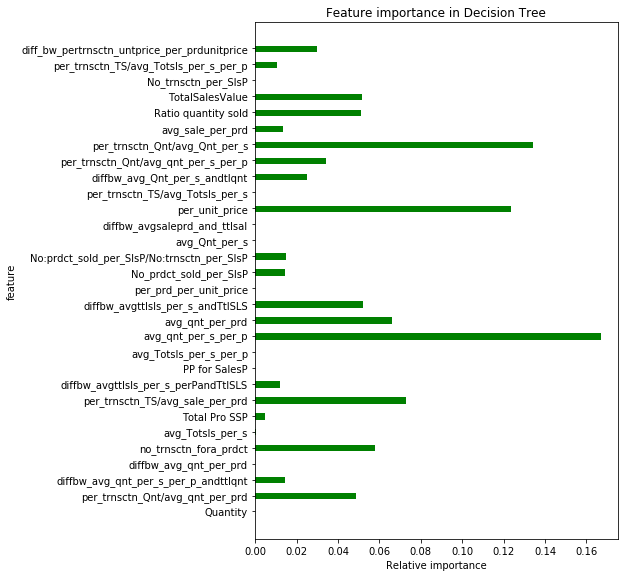

<Figure size 360x504 with 0 Axes>

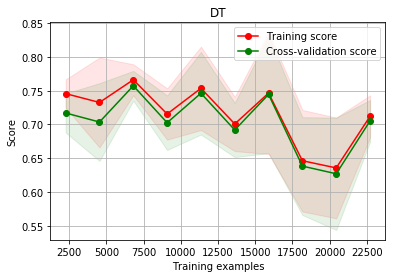

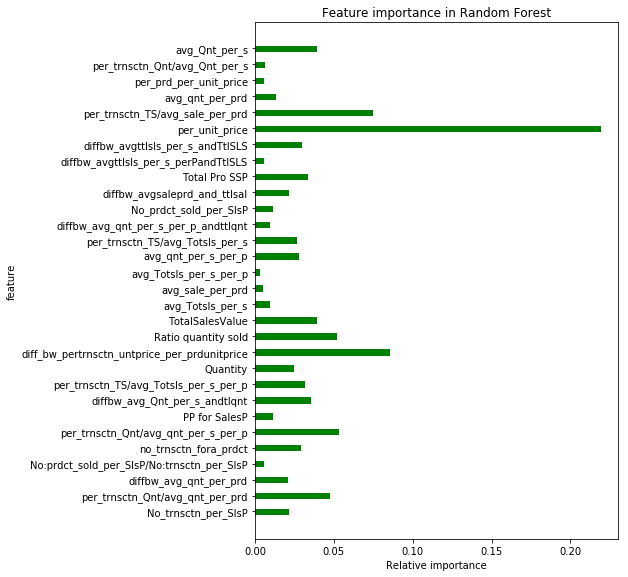

<Figure size 360x504 with 0 Axes>

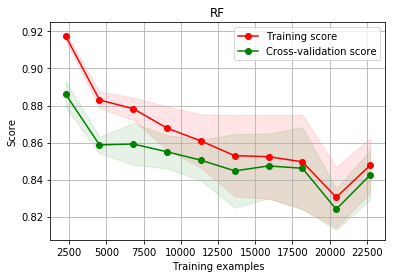

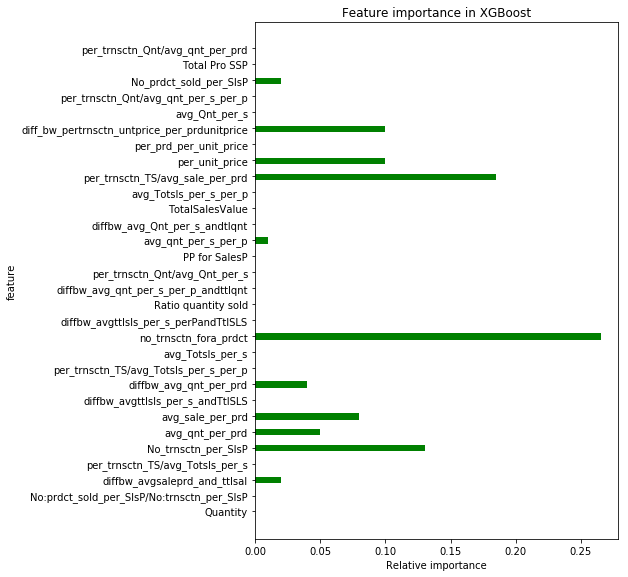

<Figure size 360x504 with 0 Axes>

In [224]:
dt_test_pred = decision_tree(test_std,X_train,y_train,X_test,y_test)
rf_test_pred = random_forest(test_std,X_train,y_train,X_test,y_test)
sgd_test_pred = sgd(test_std,X_train,y_train,X_test,y_test)
xg_test_pred = xgboost(test_std,X_train,y_train,X_test,y_test)


In [225]:
data.columns

Index(['Quantity', 'TotalSalesValue', 'Suspicious', 'per_unit_price',
       'avg_qnt_per_s_per_p', 'PP for SalesP', 'Total Pro SSP',
       'per_prd_per_unit_price',
       'diff_bw_pertrnsctn_untprice_per_prdunitprice', 'no_trnsctn_fora_prdct',
       'avg_Totsls_per_s_per_p', 'avg_Totsls_per_s', 'avg_Qnt_per_s',
       'avg_sale_per_prd', 'avg_qnt_per_prd', 'No_trnsctn_per_SlsP',
       'No_prdct_sold_per_SlsP', 'No:prdct_sold_per_SlsP/No:trnsctn_per_SlsP',
       'per_trnsctn_TS/avg_Totsls_per_s_per_p',
       'per_trnsctn_TS/avg_sale_per_prd', 'per_trnsctn_TS/avg_Totsls_per_s',
       'per_trnsctn_Qnt/avg_qnt_per_s_per_p', 'per_trnsctn_Qnt/avg_Qnt_per_s',
       'per_trnsctn_Qnt/avg_qnt_per_prd', 'Ratio quantity sold',
       'diffbw_avgttlsls_per_s_perPandTtlSLS',
       'diffbw_avgttlsls_per_s_andTtlSLS', 'diffbw_avgsaleprd_and_ttlsal',
       'diffbw_avg_qnt_per_s_per_p_andttlqnt', 'diffbw_avg_Qnt_per_s_andtlqnt',
       'diffbw_avg_qnt_per_prd'],
      dtype='object')

## Important Features

In [226]:
train_data=data.drop(["PP for SalesP",'diffbw_avgttlsls_per_s_perPandTtlSLS','avg_sale_per_prd','avg_Totsls_per_s',
                     'No_prdct_sold_per_SlsP','avg_qnt_per_prd','avg_Totsls_per_s_per_p','per_trnsctn_TS/avg_Totsls_per_s_per_p',
                     'per_prd_per_unit_price','diffbw_avg_Qnt_per_s_andtlqnt','No_trnsctn_per_SlsP'],axis=1)

In [227]:
test_data=test.drop(["PP for SalesP",'diffbw_avgttlsls_per_s_perPandTtlSLS','avg_sale_per_prd','avg_Totsls_per_s',
                     'No_prdct_sold_per_SlsP','avg_qnt_per_prd','avg_Totsls_per_s_per_p','per_trnsctn_TS/avg_Totsls_per_s_per_p',
                     'per_prd_per_unit_price','diffbw_avg_Qnt_per_s_andtlqnt','No_trnsctn_per_SlsP'],axis=1)

In [228]:
print(train_data.shape)
print(test_data.shape)

(42582, 20)
(9135, 19)


In [229]:
y_r=train_data.Suspicious
X_r=train_data.drop("Suspicious",axis=1)

In [230]:
scale=StandardScaler().fit(X_r)
X_data_std=scale.transform(X_r)
test_data_std=scale.transform(test_data)

C:\Users\karthik\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\karthik\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\karthik\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [231]:
X_train, X_test, y_train, y_test = train_test_split(X_data_std, y_r, test_size=0.20,stratify=y_r)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(34065, 19)
(8517, 19)
(34065,)
(8517,)


------------------------------ Decision_Tree
               precision    recall  f1-score   support

           No       0.13      0.79      0.23      2044
          Yes       0.13      0.86      0.23       145
indeterminate       0.98      0.64      0.78     31876

    micro avg       0.65      0.65      0.65     34065
    macro avg       0.41      0.76      0.41     34065
 weighted avg       0.93      0.65      0.74     34065

               precision    recall  f1-score   support

           No       0.12      0.77      0.21       511
          Yes       0.10      0.64      0.17        36
indeterminate       0.98      0.62      0.76      7970

    micro avg       0.63      0.63      0.63      8517
    macro avg       0.40      0.68      0.38      8517
 weighted avg       0.92      0.63      0.73      8517



C:\Users\karthik\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.7619908784978935
0.6780891168947406
------------------------------ Random Forest


C:\Users\karthik\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


               precision    recall  f1-score   support

           No       0.23      0.68      0.34      2044
          Yes       0.38      0.86      0.53       145
indeterminate       0.98      0.85      0.91     31876

    micro avg       0.84      0.84      0.84     34065
    macro avg       0.53      0.80      0.59     34065
 weighted avg       0.93      0.84      0.87     34065

               precision    recall  f1-score   support

           No       0.22      0.68      0.33       511
          Yes       0.27      0.53      0.36        36
indeterminate       0.97      0.84      0.90      7970

    micro avg       0.83      0.83      0.83      8517
    macro avg       0.49      0.68      0.53      8517
 weighted avg       0.93      0.83      0.87      8517

0.7951947518545425
0.6814264125027089
------------------------------ SGD


C:\Users\karthik\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

           No       0.41      0.04      0.07      2044
          Yes       0.57      0.23      0.33       145
indeterminate       0.94      1.00      0.97     31876

    micro avg       0.94      0.94      0.94     34065
    macro avg       0.64      0.42      0.45     34065
 weighted avg       0.91      0.94      0.91     34065

               precision    recall  f1-score   support

           No       0.36      0.03      0.06       511
          Yes       0.69      0.25      0.37        36
indeterminate       0.94      1.00      0.97      7970

    micro avg       0.94      0.94      0.94      8517
    macro avg       0.66      0.43      0.46      8517
 weighted avg       0.90      0.94      0.91      8517

0.42058749594417894
0.4264595052713167
------------------------------ XGBoost
               precision    recall  f1-score   support

           No       0.70      0.12      0.21      2044
          Yes       1.00      0.13 

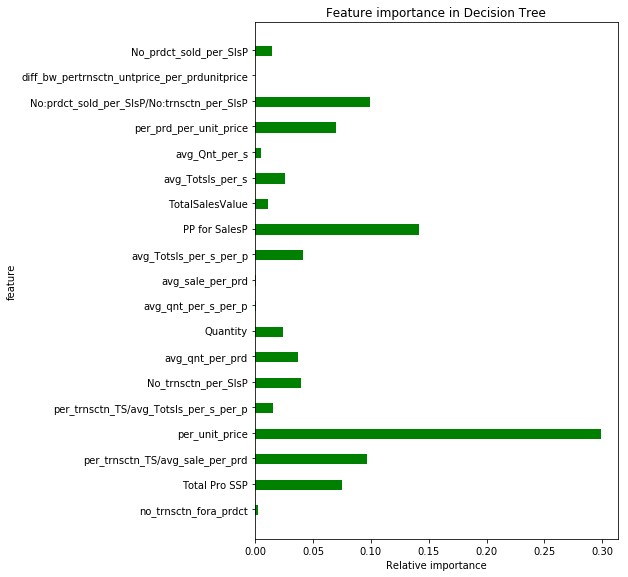

<Figure size 360x504 with 0 Axes>

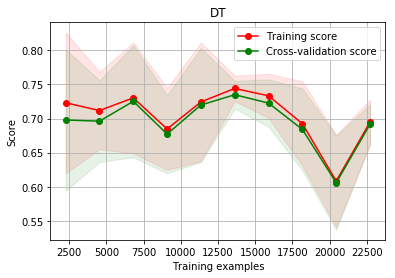

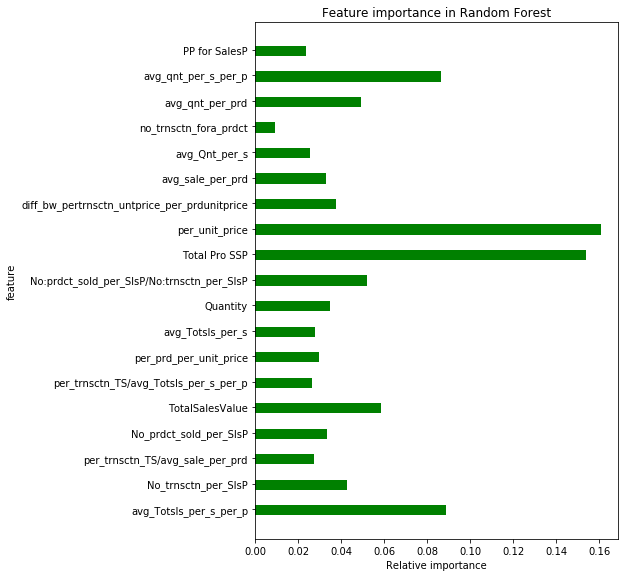

<Figure size 360x504 with 0 Axes>

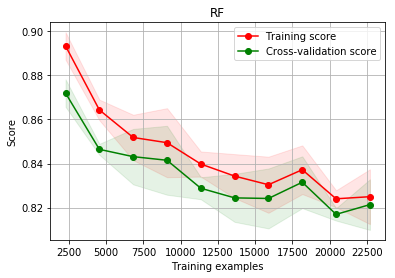

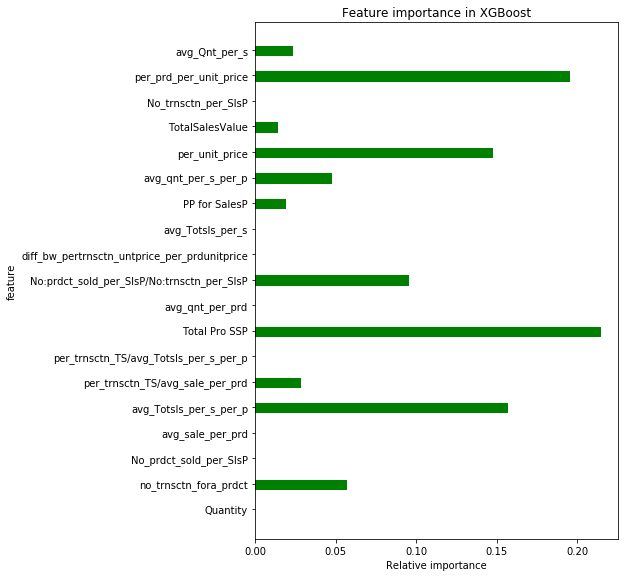

<Figure size 360x504 with 0 Axes>

In [232]:
dt_test_pred_rm = decision_tree(test_data_std,X_train,y_train,X_test,y_test)
rf_test_pred_rm = random_forest(test_data_std,X_train,y_train,X_test,y_test)
sgd_test_pred_rm = sgd(test_data_std,X_train,y_train,X_test,y_test)
xg_test_pred_rm = xgboost(test_data_std,X_train,y_train,X_test,y_test)


In [233]:
X_train.shape

(34065, 19)

## High variance problem is observed in the dataset.
##  we can address this problem either by cross validation , stacking or dimensionality reduction

## PCA

In [234]:
pca = PCA(n_components=11)
pc = pca.fit(X_data_std)
principalComponents=pc.transform(X_data_std)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2','pc3','pc4','pc5','pc6','pc7','pc8','pc9','pc10','pc11'])
print(principalDf.head())



        pc1       pc2       pc3       pc4       pc5       pc6       pc7  \
0 -0.537219  0.018748  0.318527  0.324164 -0.187631  0.980014  1.509629   
1 -0.525923  0.011428  0.318547  0.325992 -0.188603  0.980071  1.511260   
2 -0.915471 -0.084126  0.343633  0.756341 -0.053854  3.753617 -1.282280   
3  0.025147 -0.164579  0.860791  0.409450 -0.134049  3.740802 -1.104098   
4 -0.569097  0.009677  0.278301  0.362451 -0.141173  0.950041  1.504978   

        pc8       pc9      pc10      pc11  
0  0.121214  0.222130 -0.033046 -0.187028  
1  0.113409  0.212341 -0.039431 -0.180091  
2  0.050179  0.404062 -0.183717  0.260288  
3 -0.895294 -0.079445 -0.043260  0.115680  
4  0.293934  0.179775 -0.040680 -0.271895  


In [235]:
test_data_PCA=pc.transform(test_data_std)

In [236]:
test_data_std.shape

(9135, 19)

In [237]:
X_data_std.shape

(42582, 19)

In [238]:
X_data_PCA=principalDf
print(X_data_PCA.head())

        pc1       pc2       pc3       pc4       pc5       pc6       pc7  \
0 -0.537219  0.018748  0.318527  0.324164 -0.187631  0.980014  1.509629   
1 -0.525923  0.011428  0.318547  0.325992 -0.188603  0.980071  1.511260   
2 -0.915471 -0.084126  0.343633  0.756341 -0.053854  3.753617 -1.282280   
3  0.025147 -0.164579  0.860791  0.409450 -0.134049  3.740802 -1.104098   
4 -0.569097  0.009677  0.278301  0.362451 -0.141173  0.950041  1.504978   

        pc8       pc9      pc10      pc11  
0  0.121214  0.222130 -0.033046 -0.187028  
1  0.113409  0.212341 -0.039431 -0.180091  
2  0.050179  0.404062 -0.183717  0.260288  
3 -0.895294 -0.079445 -0.043260  0.115680  
4  0.293934  0.179775 -0.040680 -0.271895  


In [239]:
X_train, X_test, y_train, y_test = train_test_split(X_data_PCA, y_r, test_size=0.20,stratify=y_r)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(test_data_PCA.shape)

(34065, 11)
(8517, 11)
(34065,)
(8517,)
(9135, 11)


------------------------------ Decision_Tree
               precision    recall  f1-score   support

           No       0.14      0.70      0.23      2044
          Yes       0.06      0.87      0.12       145
indeterminate       0.98      0.67      0.79     31876

    micro avg       0.67      0.67      0.67     34065
    macro avg       0.39      0.75      0.38     34065
 weighted avg       0.92      0.67      0.76     34065

               precision    recall  f1-score   support

           No       0.13      0.68      0.22       511
          Yes       0.05      0.67      0.09        36
indeterminate       0.98      0.66      0.79      7970

    micro avg       0.66      0.66      0.66      8517
    macro avg       0.39      0.67      0.37      8517
 weighted avg       0.92      0.66      0.75      8517



C:\Users\karthik\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.7454248677195675
0.6700143749541319
------------------------------ Random Forest


C:\Users\karthik\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


               precision    recall  f1-score   support

           No       0.18      0.56      0.27      2044
          Yes       0.17      0.84      0.28       145
indeterminate       0.97      0.82      0.89     31876

    micro avg       0.80      0.80      0.80     34065
    macro avg       0.44      0.74      0.48     34065
 weighted avg       0.92      0.80      0.85     34065

               precision    recall  f1-score   support

           No       0.16      0.53      0.25       511
          Yes       0.11      0.58      0.19        36
indeterminate       0.96      0.81      0.88      7970

    micro avg       0.79      0.79      0.79      8517
    macro avg       0.41      0.64      0.44      8517
 weighted avg       0.91      0.79      0.84      8517

0.7389657493755756
0.6402307877196587


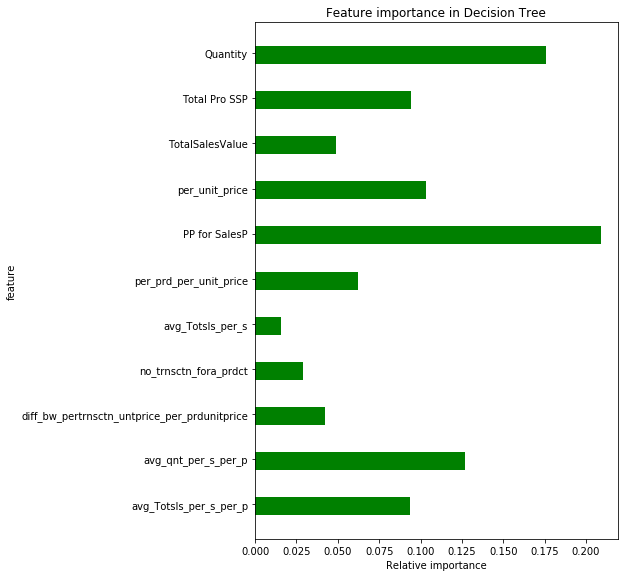

<Figure size 360x504 with 0 Axes>

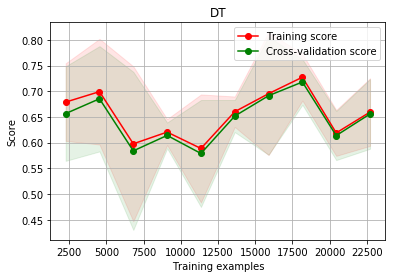

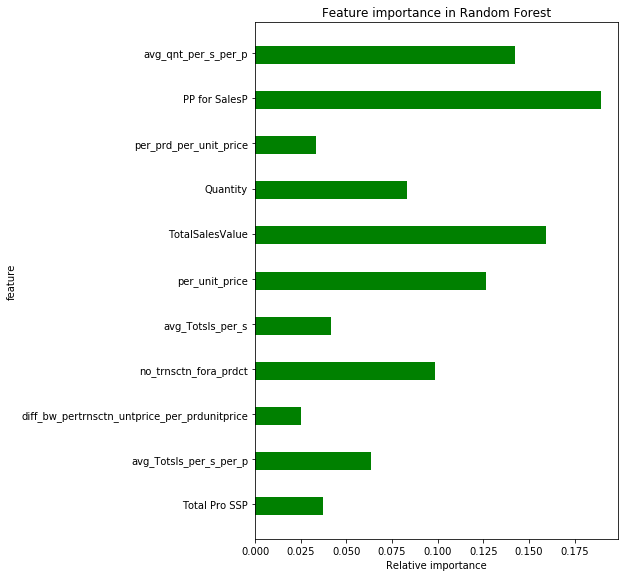

<Figure size 360x504 with 0 Axes>

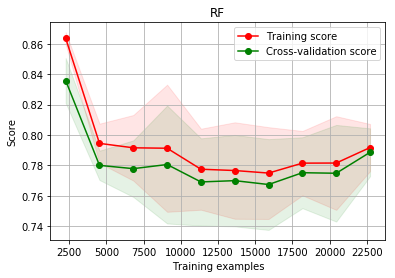

In [240]:
dt_test_pred_pca = decision_tree(test_data_PCA,X_train,y_train,X_test,y_test)
rf_test_pred_pca = random_forest(test_data_PCA,X_train,y_train,X_test,y_test)



In [241]:
X_train, X_test, y_train, y_test = train_test_split(X_data_std, y_r, test_size=0.20,stratify=y_r)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(34065, 19)
(8517, 19)
(34065,)
(8517,)


In [242]:
bag=BaggingClassifier(n_estimators=20,n_jobs=-1,random_state=7,max_features=8)
bag.fit(X_train,y_train)
pred_train_bag=bag.predict(X_train)
pred_test_bag=bag.predict(X_test)

In [243]:
print(recall_score(y_train,pred_train_bag,average='macro'))
print(recall_score(y_test,pred_test_bag,average='macro'))

0.9700745246739725
0.6436638890730433


In [244]:
test_pred_bag=bag.predict(test_data_std)

## AutoEncoder

In [245]:
data_auto=pd.read_excel("Train.xlsx",header=0)
test_auto=pd.read_excel("Test.xlsx",header=0)

In [246]:
X_auto=data_auto.drop(["ReportID","SalesPersonID","ProductID","Suspicious"],axis=1)
y_auto=data_auto.Suspicious
test_X_auto=test_auto.drop(["ReportID","SalesPersonID","ProductID"],axis=1)

In [247]:
X_auto["per_unit_price"]=data_auto.TotalSalesValue/data_auto.Quantity
test_X_auto["per_unit_price"]=test_auto.TotalSalesValue/test_auto.Quantity

In [248]:
scale_auto=StandardScaler().fit(X_auto)
X_std_auto=scale_auto.transform(X_auto)
test_X_std_auto=scale_auto.transform(test_X_auto)

C:\Users\karthik\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\karthik\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\karthik\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [249]:
X_train,X_test,y_train,y_test=train_test_split(X_std_auto,y_auto,test_size=0.2,random_state=123,stratify=y_auto)

In [250]:
encoding_dim = 10
actual_dim = X_train.shape[1]
input_img = Input(shape=(actual_dim,))
encoded = Dense(encoding_dim,activation='relu')(input_img)
decoded = Dense(actual_dim,activation='softmax')(encoded)
autoencoder = Model(input_img,decoded)
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 33        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
None


In [251]:
autoencoder.compile(optimizer='adadelta', loss='categorical_crossentropy')
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32)

Epoch 1/100
34065/34065 [==============================] - 1s 28us/step - loss: -1.9432
Epoch 2/100
34065/34065 [==============================] - 1s 20us/step - loss: -3.0303
Epoch 3/100
34065/34065 [==============================] - 1s 24us/step - loss: -3.1676
Epoch 4/100
34065/34065 [==============================] - 1s 24us/step - loss: -3.2428
Epoch 5/100
34065/34065 [==============================] - 1s 24us/step - loss: -3.3061
Epoch 6/100
34065/34065 [==============================] - 1s 23us/step - loss: -3.3528
Epoch 7/100
34065/34065 [==============================] - 1s 23us/step - loss: -3.3893
Epoch 8/100
34065/34065 [==============================] - 1s 23us/step - loss: -3.4187
Epoch 9/100
34065/34065 [==============================] - 1s 23us/step - loss: -3.4443
Epoch 10/100
34065/34065 [==============================] - 1s 23us/step - loss: -3.4687
Epoch 11/100
34065/34065 [==============================] - 1s 23us/step - loss: -3.4918
Epoch 12/100
34065/34065 [====

34065/34065 [==============================] - 1s 25us/step - loss: -3.8331
Epoch 94/100
34065/34065 [==============================] - 1s 23us/step - loss: -3.8332
Epoch 95/100
34065/34065 [==============================] - 1s 23us/step - loss: -3.8334
Epoch 96/100
34065/34065 [==============================] - 1s 23us/step - loss: -3.8338
Epoch 97/100
34065/34065 [==============================] - 1s 23us/step - loss: -3.8347
Epoch 98/100
34065/34065 [==============================] - 1s 23us/step - loss: -3.8350
Epoch 99/100
34065/34065 [==============================] - 1s 23us/step - loss: -3.8357
Epoch 100/100
34065/34065 [==============================] - 1s 23us/step - loss: -3.8361


In [252]:
encoder=Model(input_img,encoded)
print(encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                40        
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________
None


In [253]:
X_train_nonLinear_features = encoder.predict(X_train)
X_test_nonLinear_features = encoder.predict(X_test)

In [254]:
test_nonLinear_features=encoder.predict(test_X_std_auto)

In [255]:
X_train=np.concatenate((X_train, X_train_nonLinear_features), axis=1)
X_test=np.concatenate((X_test,X_test_nonLinear_features),axis=1)
test_X_std_auto=np.concatenate((test_X_std_auto,test_nonLinear_features),axis=1)

In [256]:
print(X_train.shape)
print(X_test.shape)
print(test_X_std_auto.shape)

(34065, 13)
(8517, 13)
(9135, 13)


In [257]:
clf=RandomForestClassifier(n_estimators=20,max_depth=5,class_weight='balanced',random_state=12,min_samples_leaf=4,
                            min_samples_split=5,criterion='entropy')
clf.fit(X=X_train, y=y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=None, oob_score=False, random_state=12,
            verbose=0, warm_start=False)

In [258]:
y_pred = clf.predict(X_train)
print(recall_score(y_train,y_pred,average='macro'))

0.7277133969033845


In [259]:
y_pred_test= clf.predict(X_test)
print(recall_score(y_test,y_pred_test,average='macro'))

0.6713586791593357


In [260]:
dt=DecisionTreeClassifier(max_depth=5,min_samples_split=2, random_state=123, class_weight='balanced', max_features=8)
dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=123, splitter='best')

In [261]:
pred_train_dt=dt.predict(X_train)
print(recall_score(y_train,pred_train_dt,average='macro'))

0.7192896271328385


In [262]:
pred_test_dt=dt.predict(X_test)
print(recall_score(y_test,pred_test_dt,average='macro'))

0.6736382420523291


In [263]:
pred_test_rf_auto=clf.predict(test_X_std_auto)
pred_test_dt_auto=dt.predict(test_X_std_auto)

In [264]:
stack=pd.DataFrame()

In [265]:
stack["dt_auto"]=pred_test_dt_auto
stack["rf_auto"]=pred_test_rf_auto
stack["dt_PCA"]=dt_test_pred_pca
stack["rf_PCA"]=rf_test_pred_pca
stack["dt_rm"]=dt_test_pred_rm
stack["rf_rm"]=rf_test_pred_rm
stack.head()

,dt_auto,rf_auto,dt_PCA,rf_PCA,dt_rm,rf_rm
0,No,No,indeterminate,indeterminate,indeterminate,indeterminate
1,No,No,indeterminate,indeterminate,indeterminate,indeterminate
2,indeterminate,indeterminate,No,indeterminate,No,indeterminate
3,No,No,indeterminate,indeterminate,indeterminate,indeterminate
4,No,indeterminate,indeterminate,indeterminate,indeterminate,indeterminate


In [266]:
stack.replace(["Yes","No","indeterminate"],[1,2,3],inplace=True)

In [267]:
import statistics
stack["mo"]=0
stack.mo=stack.mode(axis=1)
stack.mo=stack.mo.astype(int)

In [268]:
sample=pd.read_csv("samplesubmission-1558719607492.csv",header=0)
sample.head()
sample.Suspicious=stack.mo
sample.Suspicious.value_counts()

3    7571
2    1468
1      96
Name: Suspicious, dtype: int64

In [ ]:
sample.to_csv("Stacked.csv",index=False)